# Training

In [1]:
import time

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

In [4]:
from src.starcattovae.training.data import Data

from src.starcattovae.nn.vae import VAE
from src.starcattovae.nn.cvae import CVAE
from src.starcattovae.nn.cvae import Encoder, Decoder, Q

In [ ]:
from src.starcattovae.plotting import plot_loss
from src.starcattovae.plotting import plot_individual_loss
from src.starcattovae.plotting import plot_training_validation_loss
from src.starcattovae.plotting import plot_reconstruction
from src.starcattovae.plotting import plot_waveform_grid
from src.starcattovae.plotting import plot_latent_morphs
from src.starcattovae.plotting import animate_latent_morphs
from src.starcattovae.plotting import plot_signal_distribution
from src.starcattovae.plotting import plot_single_signal
from src.starcattovae.plotting import plot_gradients

In [6]:
manualSeed = 99
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # reproducibility

### Define Parameters

In [ ]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

# model parameters
batch_size = 32
epochs = 128 # need to change this to max epochs so we have early stopping

signal_dim = 256
hidden_dim = 512
latent_dim = 32
lr = 1e-4

multi_param = False
log_beta = False

if multi_param:
    param_dim = 27
else:
    param_dim = 1

Using device: mps


## Load Training Data

In [8]:
np.random.seed(42)
indices = np.arange(1684) # this is the number of signals minus all the signals with beta_IC_b less than 0
np.random.shuffle(indices)
split_ratio = 0.9
split_idx = int(len(indices) * split_ratio)
train_indices = indices[:split_idx]
validation_indices = indices[split_idx:]

# Create train and validation datasets
train_dataset = Data(indices=train_indices, train=True, multi_param=multi_param)
validation_dataset = Data(indices=validation_indices, train=False, multi_param=multi_param)

# Check for overlap
train_indices_set = set(train_dataset.get_indices())
validation_indices_set = set(validation_dataset.get_indices())

overlap = train_indices_set.intersection(validation_indices_set)
if len(overlap) == 0:
    print("Train and validation sets are different.")
else:
    print("Train and validation sets have overlap.")

Train and validation sets are different.


In [9]:
train_dataset.summary()
validation_dataset.summary()

2025-05-14 20:09:46.618 | INFO     | src.starcattovae.training.data:summary:118 - Signal Dataset mean: -0.524 +/- 39.879
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 656.2575073242188
Signal Dataset shape: (256, 1515)
Parameter Dataset shape: (1515, 1)

2025-05-14 20:09:46.618 | INFO     | src.starcattovae.training.data:summary:118 - Signal Dataset mean: -0.444 +/- 38.309
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 626.9296875
Signal Dataset shape: (256, 169)
Parameter Dataset shape: (169, 1)



In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [11]:
for batch in train_dataloader:  # train_dataloader is the DataLoader object
    data_example, param = batch  # Unpack batch
    data_shape = data_example.shape
    condition_dim = param.shape[1] if len(param.shape) > 1 else 1  # Assuming batch first

    print(f"Data shape: {data_shape}")
    print(f"Parameter shape: {param.shape}")
    print(f"Parameter example: {param[0]}")
    break  # Only process the first batch

Data shape: torch.Size([32, 1, 256])
Parameter shape: torch.Size([32, 1, 1])
Parameter example: tensor([[0.1741]])


## Load VAE

In [12]:
cvae = CVAE(latent_dim=latent_dim, hidden_dim=hidden_dim, param_dim=param_dim, signal_dim=signal_dim, num_epochs=epochs, DEVICE=DEVICE).to(DEVICE)

### Optimiser

In [13]:
optimizer = Adam(cvae.parameters(), lr=lr)

### Train VAE

#### CVAE Training

Start training CVAE...


Training:   1%|          | 1/128 [00:04<09:57,  4.71s/it]

Epoch 1, Train Loss: 5.0950
Epoch 1, Train Reproduction Loss: -4.9687
Epoch 1, Train KLD Loss: 0.1263


Training:   2%|▏         | 2/128 [00:08<09:02,  4.31s/it]

Epoch 2, Train Loss: 2.7165
Epoch 2, Train Reproduction Loss: -2.6219
Epoch 2, Train KLD Loss: 0.0946


Training:   2%|▏         | 3/128 [00:12<08:42,  4.18s/it]

Epoch 3, Train Loss: 2.2109
Epoch 3, Train Reproduction Loss: -2.1018
Epoch 3, Train KLD Loss: 0.1091


Training:   3%|▎         | 4/128 [00:16<08:36,  4.17s/it]

Epoch 4, Train Loss: 2.0188
Epoch 4, Train Reproduction Loss: -1.9199
Epoch 4, Train KLD Loss: 0.0989


Training:   4%|▍         | 5/128 [00:21<08:34,  4.19s/it]

Epoch 5, Train Loss: 1.8818
Epoch 5, Train Reproduction Loss: -1.7856
Epoch 5, Train KLD Loss: 0.0962


Training:   5%|▍         | 6/128 [00:25<08:31,  4.19s/it]

Epoch 6, Train Loss: 1.7943
Epoch 6, Train Reproduction Loss: -1.7066
Epoch 6, Train KLD Loss: 0.0877


Training:   5%|▌         | 7/128 [00:29<08:21,  4.14s/it]

Epoch 7, Train Loss: 1.7409
Epoch 7, Train Reproduction Loss: -1.6561
Epoch 7, Train KLD Loss: 0.0848


Training:   6%|▋         | 8/128 [00:33<08:15,  4.13s/it]

Epoch 8, Train Loss: 1.6283
Epoch 8, Train Reproduction Loss: -1.5479
Epoch 8, Train KLD Loss: 0.0804


Training:   7%|▋         | 9/128 [00:37<08:22,  4.22s/it]

Epoch 9, Train Loss: 1.5540
Epoch 9, Train Reproduction Loss: -1.4689
Epoch 9, Train KLD Loss: 0.0852
Epoch 10, Train Loss: 1.4531
Epoch 10, Train Reproduction Loss: -1.3735
Epoch 10, Train KLD Loss: 0.0796
(1, 1)
(1,)


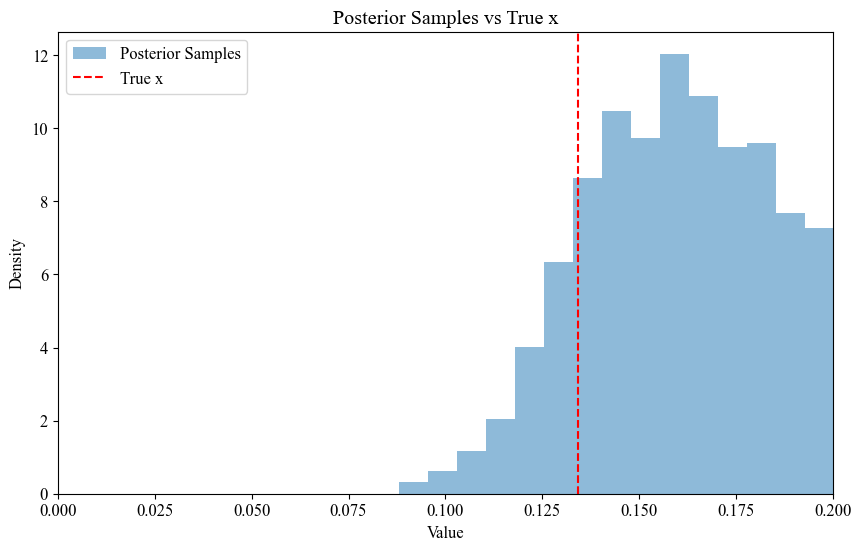

Training:   9%|▊         | 11/128 [01:00<13:55,  7.14s/it]

Epoch 11, Train Loss: 1.3822
Epoch 11, Train Reproduction Loss: -1.2956
Epoch 11, Train KLD Loss: 0.0865


Training:   9%|▉         | 12/128 [01:04<11:57,  6.18s/it]

Epoch 12, Train Loss: 1.2535
Epoch 12, Train Reproduction Loss: -1.1609
Epoch 12, Train KLD Loss: 0.0926


Training:  10%|█         | 13/128 [01:07<10:34,  5.52s/it]

Epoch 13, Train Loss: 1.1557
Epoch 13, Train Reproduction Loss: -1.0640
Epoch 13, Train KLD Loss: 0.0917


Training:  11%|█         | 14/128 [01:12<09:38,  5.07s/it]

Epoch 14, Train Loss: 1.0446
Epoch 14, Train Reproduction Loss: -0.9507
Epoch 14, Train KLD Loss: 0.0939


Training:  12%|█▏        | 15/128 [01:16<08:56,  4.75s/it]

Epoch 15, Train Loss: 0.9792
Epoch 15, Train Reproduction Loss: -0.8759
Epoch 15, Train KLD Loss: 0.1033


Training:  12%|█▎        | 16/128 [01:20<08:26,  4.52s/it]

Epoch 16, Train Loss: 0.8851
Epoch 16, Train Reproduction Loss: -0.7856
Epoch 16, Train KLD Loss: 0.0995


Training:  13%|█▎        | 17/128 [01:24<08:04,  4.36s/it]

Epoch 17, Train Loss: 0.8159
Epoch 17, Train Reproduction Loss: -0.7157
Epoch 17, Train KLD Loss: 0.1002


Training:  14%|█▍        | 18/128 [01:28<07:48,  4.25s/it]

Epoch 18, Train Loss: 0.7937
Epoch 18, Train Reproduction Loss: -0.6989
Epoch 18, Train KLD Loss: 0.0948


Training:  15%|█▍        | 19/128 [01:32<07:35,  4.18s/it]

Epoch 19, Train Loss: 0.7450
Epoch 19, Train Reproduction Loss: -0.6522
Epoch 19, Train KLD Loss: 0.0928
Epoch 20, Train Loss: 0.6636
Epoch 20, Train Reproduction Loss: -0.5732
Epoch 20, Train KLD Loss: 0.0903
(1, 1)
(1,)


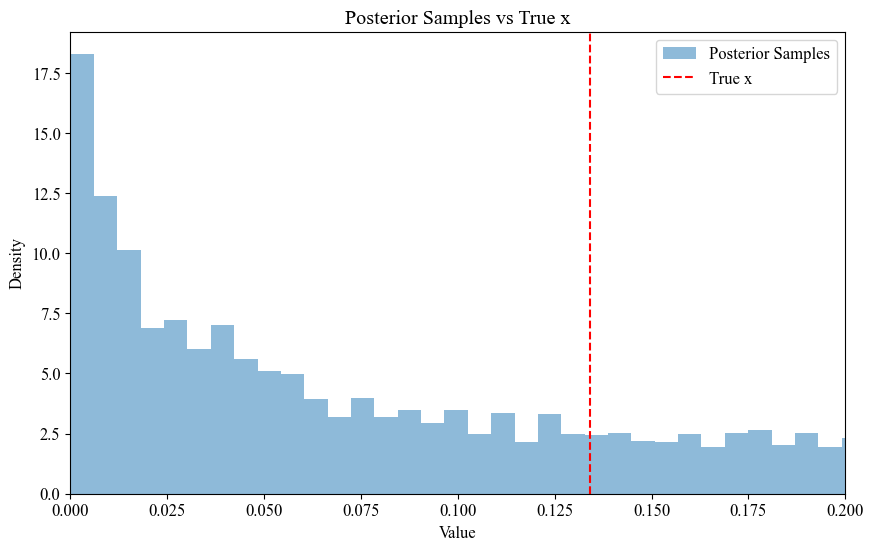

Training:  16%|█▋        | 21/128 [01:52<12:07,  6.80s/it]

Epoch 21, Train Loss: 0.5917
Epoch 21, Train Reproduction Loss: -0.5017
Epoch 21, Train KLD Loss: 0.0900


Training:  17%|█▋        | 22/128 [01:56<10:31,  5.95s/it]

Epoch 22, Train Loss: 0.6701
Epoch 22, Train Reproduction Loss: -0.5796
Epoch 22, Train KLD Loss: 0.0905


Training:  18%|█▊        | 23/128 [02:00<09:22,  5.36s/it]

Epoch 23, Train Loss: 0.6506
Epoch 23, Train Reproduction Loss: -0.5591
Epoch 23, Train KLD Loss: 0.0915


Training:  19%|█▉        | 24/128 [02:04<08:35,  4.96s/it]

Epoch 24, Train Loss: 0.4969
Epoch 24, Train Reproduction Loss: -0.4060
Epoch 24, Train KLD Loss: 0.0909


Training:  20%|█▉        | 25/128 [02:09<08:04,  4.71s/it]

Epoch 25, Train Loss: 0.5300
Epoch 25, Train Reproduction Loss: -0.4393
Epoch 25, Train KLD Loss: 0.0907


Training:  20%|██        | 26/128 [02:13<07:43,  4.55s/it]

Epoch 26, Train Loss: 0.5581
Epoch 26, Train Reproduction Loss: -0.4678
Epoch 26, Train KLD Loss: 0.0903


Training:  21%|██        | 27/128 [02:17<07:24,  4.40s/it]

Epoch 27, Train Loss: 0.4942
Epoch 27, Train Reproduction Loss: -0.4023
Epoch 27, Train KLD Loss: 0.0919


Training:  22%|██▏       | 28/128 [02:21<07:14,  4.35s/it]

Epoch 28, Train Loss: 0.4527
Epoch 28, Train Reproduction Loss: -0.3606
Epoch 28, Train KLD Loss: 0.0921


Training:  23%|██▎       | 29/128 [02:25<07:04,  4.29s/it]

Epoch 29, Train Loss: 0.4930
Epoch 29, Train Reproduction Loss: -0.4012
Epoch 29, Train KLD Loss: 0.0918
Epoch 30, Train Loss: 0.3829
Epoch 30, Train Reproduction Loss: -0.2919
Epoch 30, Train KLD Loss: 0.0910
(1, 1)
(1,)


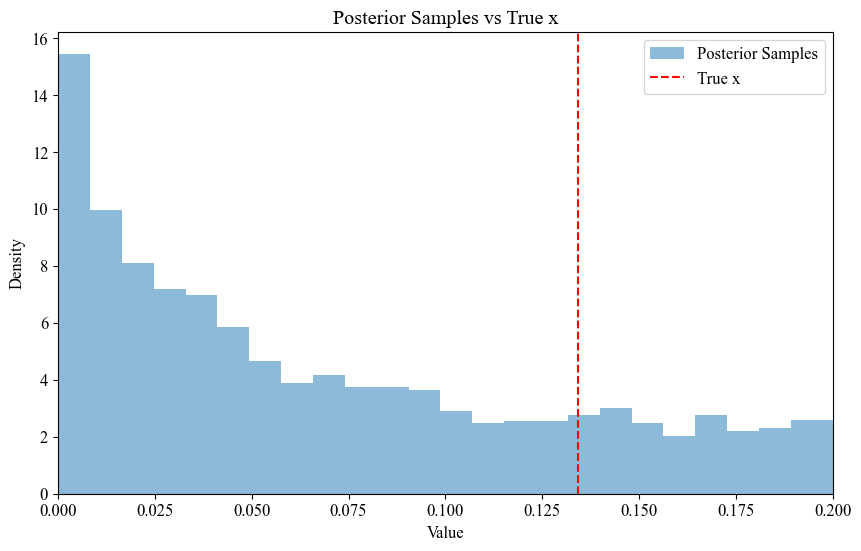

Training:  24%|██▍       | 31/128 [02:46<11:14,  6.95s/it]

Epoch 31, Train Loss: 0.2996
Epoch 31, Train Reproduction Loss: -0.2080
Epoch 31, Train KLD Loss: 0.0916


Training:  25%|██▌       | 32/128 [02:51<09:47,  6.12s/it]

Epoch 32, Train Loss: 0.5390
Epoch 32, Train Reproduction Loss: -0.4438
Epoch 32, Train KLD Loss: 0.0952


Training:  26%|██▌       | 33/128 [02:55<08:41,  5.49s/it]

Epoch 33, Train Loss: 0.3622
Epoch 33, Train Reproduction Loss: -0.2704
Epoch 33, Train KLD Loss: 0.0918


Training:  27%|██▋       | 34/128 [02:59<07:54,  5.04s/it]

Epoch 34, Train Loss: 0.3725
Epoch 34, Train Reproduction Loss: -0.2807
Epoch 34, Train KLD Loss: 0.0918


Training:  27%|██▋       | 35/128 [03:03<07:24,  4.77s/it]

Epoch 35, Train Loss: 0.4059
Epoch 35, Train Reproduction Loss: -0.3146
Epoch 35, Train KLD Loss: 0.0913


Training:  28%|██▊       | 36/128 [03:07<07:00,  4.57s/it]

Epoch 36, Train Loss: 0.2427
Epoch 36, Train Reproduction Loss: -0.1519
Epoch 36, Train KLD Loss: 0.0907


Training:  29%|██▉       | 37/128 [03:11<06:43,  4.43s/it]

Epoch 37, Train Loss: 0.3653
Epoch 37, Train Reproduction Loss: -0.2752
Epoch 37, Train KLD Loss: 0.0902


Training:  30%|██▉       | 38/128 [03:15<06:26,  4.29s/it]

Epoch 38, Train Loss: 0.2941
Epoch 38, Train Reproduction Loss: -0.2026
Epoch 38, Train KLD Loss: 0.0915


Training:  30%|███       | 39/128 [03:19<06:16,  4.23s/it]

Epoch 39, Train Loss: 0.2791
Epoch 39, Train Reproduction Loss: -0.1879
Epoch 39, Train KLD Loss: 0.0912
Epoch 40, Train Loss: 0.3208
Epoch 40, Train Reproduction Loss: -0.2305
Epoch 40, Train KLD Loss: 0.0903
(1, 1)
(1,)


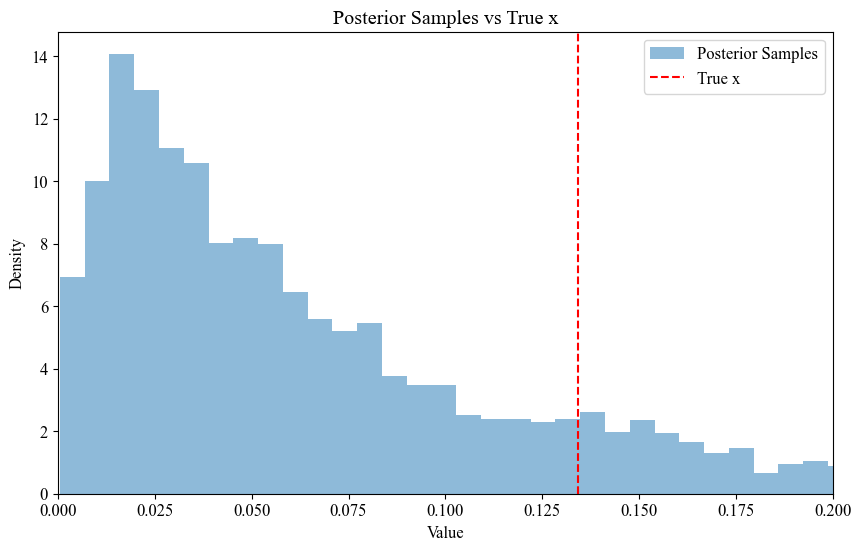

Training:  32%|███▏      | 41/128 [03:40<10:03,  6.94s/it]

Epoch 41, Train Loss: 0.2772
Epoch 41, Train Reproduction Loss: -0.1884
Epoch 41, Train KLD Loss: 0.0888


Training:  33%|███▎      | 42/128 [03:44<08:41,  6.06s/it]

Epoch 42, Train Loss: 0.3242
Epoch 42, Train Reproduction Loss: -0.2342
Epoch 42, Train KLD Loss: 0.0900


Training:  34%|███▎      | 43/128 [03:49<07:43,  5.46s/it]

Epoch 43, Train Loss: 0.2350
Epoch 43, Train Reproduction Loss: -0.1441
Epoch 43, Train KLD Loss: 0.0909


Training:  34%|███▍      | 44/128 [03:53<07:04,  5.06s/it]

Epoch 44, Train Loss: 0.1741
Epoch 44, Train Reproduction Loss: -0.0829
Epoch 44, Train KLD Loss: 0.0913


Training:  35%|███▌      | 45/128 [03:57<06:37,  4.79s/it]

Epoch 45, Train Loss: 0.2100
Epoch 45, Train Reproduction Loss: -0.1170
Epoch 45, Train KLD Loss: 0.0930


Training:  36%|███▌      | 46/128 [04:01<06:20,  4.64s/it]

Epoch 46, Train Loss: 0.3644
Epoch 46, Train Reproduction Loss: -0.2709
Epoch 46, Train KLD Loss: 0.0936


Training:  37%|███▋      | 47/128 [04:05<06:04,  4.50s/it]

Epoch 47, Train Loss: 0.3039
Epoch 47, Train Reproduction Loss: -0.2111
Epoch 47, Train KLD Loss: 0.0929


Training:  38%|███▊      | 48/128 [04:09<05:49,  4.37s/it]

Epoch 48, Train Loss: 0.3477
Epoch 48, Train Reproduction Loss: -0.2573
Epoch 48, Train KLD Loss: 0.0903


Training:  38%|███▊      | 49/128 [04:13<05:38,  4.28s/it]

Epoch 49, Train Loss: 0.2218
Epoch 49, Train Reproduction Loss: -0.1333
Epoch 49, Train KLD Loss: 0.0885
Epoch 50, Train Loss: 0.2681
Epoch 50, Train Reproduction Loss: -0.1785
Epoch 50, Train KLD Loss: 0.0896
(1, 1)
(1,)


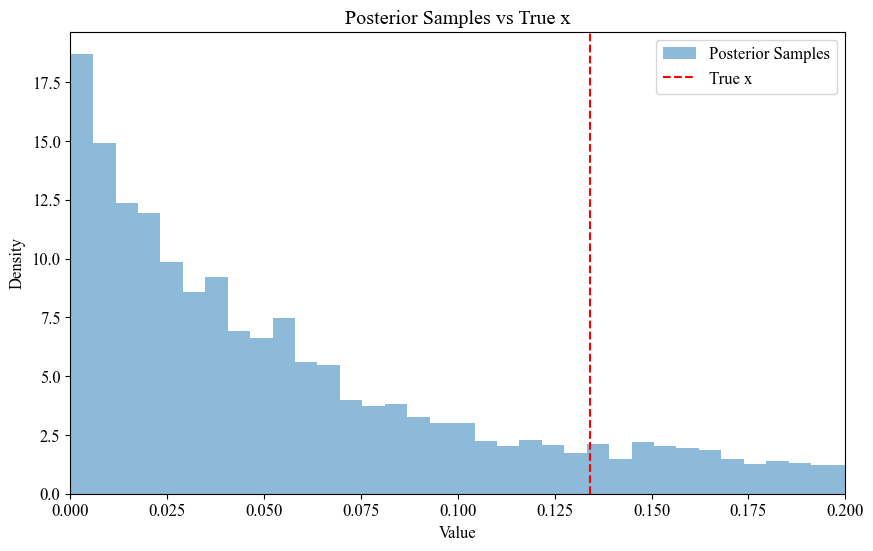

Training:  40%|███▉      | 51/128 [04:35<09:00,  7.01s/it]

Epoch 51, Train Loss: 0.2043
Epoch 51, Train Reproduction Loss: -0.1163
Epoch 51, Train KLD Loss: 0.0880


Training:  41%|████      | 52/128 [04:39<07:46,  6.14s/it]

Epoch 52, Train Loss: 0.2208
Epoch 52, Train Reproduction Loss: -0.1332
Epoch 52, Train KLD Loss: 0.0875


Training:  41%|████▏     | 53/128 [04:43<06:49,  5.46s/it]

Epoch 53, Train Loss: 0.2235
Epoch 53, Train Reproduction Loss: -0.1347
Epoch 53, Train KLD Loss: 0.0888


Training:  42%|████▏     | 54/128 [04:47<06:08,  4.98s/it]

Epoch 54, Train Loss: 0.1908
Epoch 54, Train Reproduction Loss: -0.1006
Epoch 54, Train KLD Loss: 0.0903


Training:  43%|████▎     | 55/128 [04:51<05:40,  4.67s/it]

Epoch 55, Train Loss: 0.1666
Epoch 55, Train Reproduction Loss: -0.0780
Epoch 55, Train KLD Loss: 0.0886


Training:  44%|████▍     | 56/128 [04:55<05:22,  4.48s/it]

Epoch 56, Train Loss: 0.2675
Epoch 56, Train Reproduction Loss: -0.1776
Epoch 56, Train KLD Loss: 0.0899


Training:  45%|████▍     | 57/128 [04:59<05:12,  4.40s/it]

Epoch 57, Train Loss: 0.2244
Epoch 57, Train Reproduction Loss: -0.1347
Epoch 57, Train KLD Loss: 0.0898


Training:  45%|████▌     | 58/128 [05:03<05:02,  4.31s/it]

Epoch 58, Train Loss: 0.2582
Epoch 58, Train Reproduction Loss: -0.1697
Epoch 58, Train KLD Loss: 0.0885


Training:  46%|████▌     | 59/128 [05:07<04:55,  4.28s/it]

Epoch 59, Train Loss: 0.3736
Epoch 59, Train Reproduction Loss: -0.2828
Epoch 59, Train KLD Loss: 0.0908
Epoch 60, Train Loss: 0.2153
Epoch 60, Train Reproduction Loss: -0.1267
Epoch 60, Train KLD Loss: 0.0885
(1, 1)
(1,)


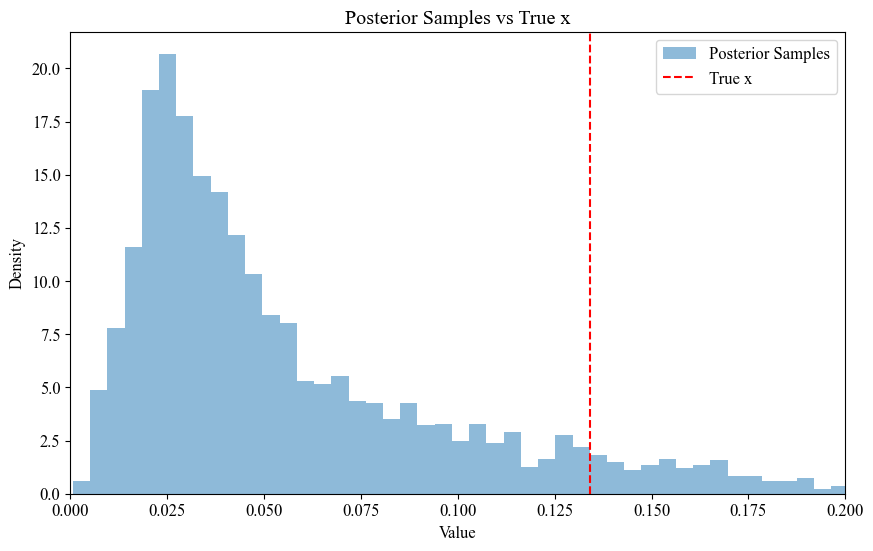

Training:  48%|████▊     | 61/128 [05:29<07:46,  6.96s/it]

Epoch 61, Train Loss: 0.1452
Epoch 61, Train Reproduction Loss: -0.0602
Epoch 61, Train KLD Loss: 0.0850


Training:  48%|████▊     | 62/128 [05:33<06:40,  6.07s/it]

Epoch 62, Train Loss: 0.1043
Epoch 62, Train Reproduction Loss: -0.0183
Epoch 62, Train KLD Loss: 0.0860


Training:  49%|████▉     | 63/128 [05:37<05:56,  5.48s/it]

Epoch 63, Train Loss: 0.2312
Epoch 63, Train Reproduction Loss: -0.1454
Epoch 63, Train KLD Loss: 0.0858


Training:  50%|█████     | 64/128 [05:41<05:22,  5.04s/it]

Epoch 64, Train Loss: 0.1519
Epoch 64, Train Reproduction Loss: -0.0664
Epoch 64, Train KLD Loss: 0.0855


Training:  51%|█████     | 65/128 [05:45<05:00,  4.77s/it]

Epoch 65, Train Loss: 0.3497
Epoch 65, Train Reproduction Loss: -0.2633
Epoch 65, Train KLD Loss: 0.0864


Training:  52%|█████▏    | 66/128 [05:49<04:43,  4.57s/it]

Epoch 66, Train Loss: 0.1682
Epoch 66, Train Reproduction Loss: -0.0830
Epoch 66, Train KLD Loss: 0.0852


Training:  52%|█████▏    | 67/128 [05:53<04:28,  4.40s/it]

Epoch 67, Train Loss: 0.1042
Epoch 67, Train Reproduction Loss: -0.0215
Epoch 67, Train KLD Loss: 0.0826


Training:  53%|█████▎    | 68/128 [05:57<04:19,  4.33s/it]

Epoch 68, Train Loss: 0.0942
Epoch 68, Train Reproduction Loss: -0.0100
Epoch 68, Train KLD Loss: 0.0843


Training:  54%|█████▍    | 69/128 [06:01<04:10,  4.25s/it]

Epoch 69, Train Loss: 0.1308
Epoch 69, Train Reproduction Loss: -0.0462
Epoch 69, Train KLD Loss: 0.0846
Epoch 70, Train Loss: 0.2530
Epoch 70, Train Reproduction Loss: -0.1664
Epoch 70, Train KLD Loss: 0.0866
(1, 1)
(1,)


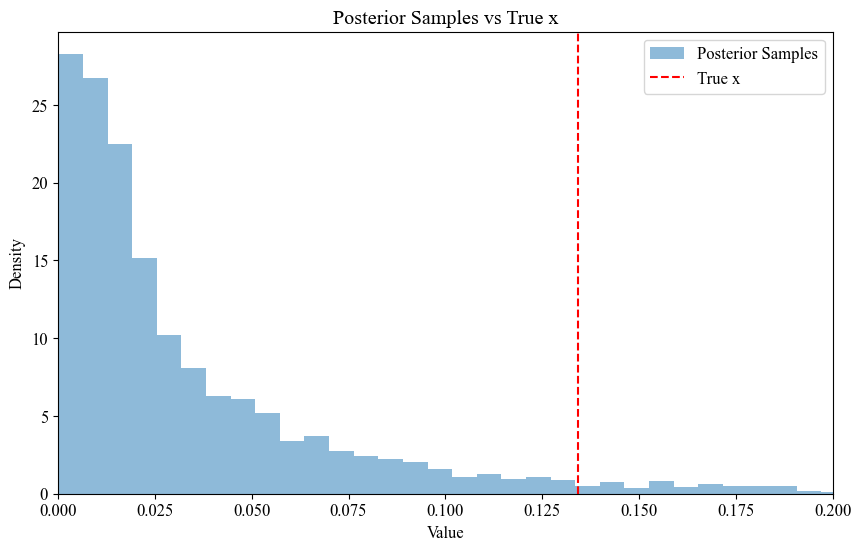

Training:  55%|█████▌    | 71/128 [06:23<06:37,  6.97s/it]

Epoch 71, Train Loss: 0.1693
Epoch 71, Train Reproduction Loss: -0.0838
Epoch 71, Train KLD Loss: 0.0854


Training:  56%|█████▋    | 72/128 [06:27<05:41,  6.10s/it]

Epoch 72, Train Loss: 0.0504
Epoch 72, Train Reproduction Loss: 0.0333
Epoch 72, Train KLD Loss: 0.0838


Training:  57%|█████▋    | 73/128 [06:31<05:01,  5.48s/it]

Epoch 73, Train Loss: 0.1814
Epoch 73, Train Reproduction Loss: -0.0962
Epoch 73, Train KLD Loss: 0.0852


Training:  58%|█████▊    | 74/128 [06:35<04:33,  5.06s/it]

Epoch 74, Train Loss: 0.2318
Epoch 74, Train Reproduction Loss: -0.1458
Epoch 74, Train KLD Loss: 0.0860


Training:  59%|█████▊    | 75/128 [06:39<04:11,  4.75s/it]

Epoch 75, Train Loss: 0.1907
Epoch 75, Train Reproduction Loss: -0.1077
Epoch 75, Train KLD Loss: 0.0831


Training:  59%|█████▉    | 76/128 [06:43<03:54,  4.51s/it]

Epoch 76, Train Loss: 0.0488
Epoch 76, Train Reproduction Loss: 0.0348
Epoch 76, Train KLD Loss: 0.0836


Training:  60%|██████    | 77/128 [06:47<03:41,  4.34s/it]

Epoch 77, Train Loss: 0.0955
Epoch 77, Train Reproduction Loss: -0.0076
Epoch 77, Train KLD Loss: 0.0879


Training:  61%|██████    | 78/128 [06:51<03:30,  4.22s/it]

Epoch 78, Train Loss: 0.1412
Epoch 78, Train Reproduction Loss: -0.0559
Epoch 78, Train KLD Loss: 0.0853


Training:  62%|██████▏   | 79/128 [06:55<03:23,  4.15s/it]

Epoch 79, Train Loss: 0.1224
Epoch 79, Train Reproduction Loss: -0.0396
Epoch 79, Train KLD Loss: 0.0828
Epoch 80, Train Loss: 0.1056
Epoch 80, Train Reproduction Loss: -0.0214
Epoch 80, Train KLD Loss: 0.0842
(1, 1)
(1,)


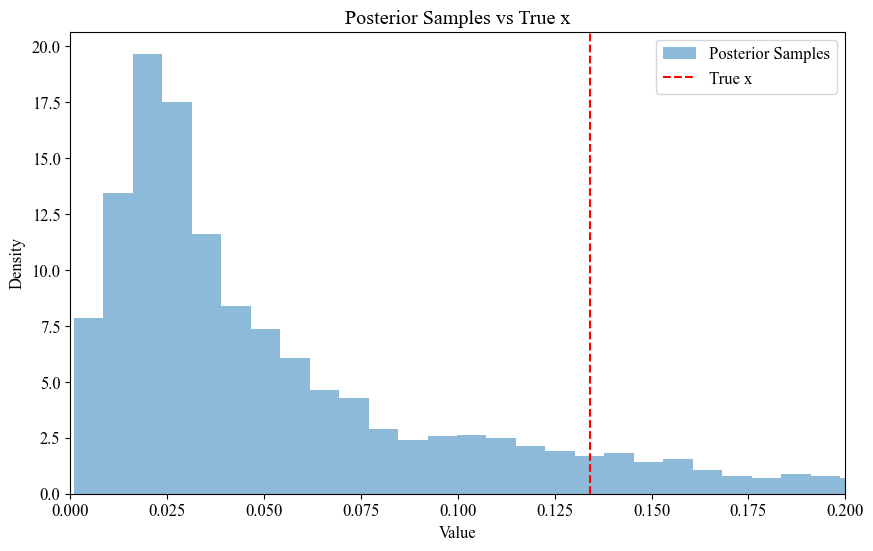

Training:  63%|██████▎   | 81/128 [07:16<05:17,  6.75s/it]

Epoch 81, Train Loss: 0.1267
Epoch 81, Train Reproduction Loss: -0.0445
Epoch 81, Train KLD Loss: 0.0822


Training:  64%|██████▍   | 82/128 [07:20<04:32,  5.92s/it]

Epoch 82, Train Loss: 0.1688
Epoch 82, Train Reproduction Loss: -0.0834
Epoch 82, Train KLD Loss: 0.0854


Training:  65%|██████▍   | 83/128 [07:24<04:00,  5.35s/it]

Epoch 83, Train Loss: 0.1213
Epoch 83, Train Reproduction Loss: -0.0394
Epoch 83, Train KLD Loss: 0.0819


Training:  66%|██████▌   | 84/128 [07:28<03:37,  4.95s/it]

Epoch 84, Train Loss: 0.0029
Epoch 84, Train Reproduction Loss: 0.0797
Epoch 84, Train KLD Loss: 0.0826


Training:  66%|██████▋   | 85/128 [07:32<03:21,  4.68s/it]

Epoch 85, Train Loss: 0.2029
Epoch 85, Train Reproduction Loss: -0.1181
Epoch 85, Train KLD Loss: 0.0849


Training:  67%|██████▋   | 86/128 [07:36<03:07,  4.46s/it]

Epoch 86, Train Loss: 0.1021
Epoch 86, Train Reproduction Loss: -0.0180
Epoch 86, Train KLD Loss: 0.0841


Training:  68%|██████▊   | 87/128 [07:40<02:56,  4.32s/it]

Epoch 87, Train Loss: 0.1430
Epoch 87, Train Reproduction Loss: -0.0608
Epoch 87, Train KLD Loss: 0.0822


Training:  69%|██████▉   | 88/128 [07:44<02:48,  4.22s/it]

Epoch 88, Train Loss: 0.0698
Epoch 88, Train Reproduction Loss: 0.0135
Epoch 88, Train KLD Loss: 0.0833


Training:  70%|██████▉   | 89/128 [07:48<02:41,  4.14s/it]

Epoch 89, Train Loss: 0.0769
Epoch 89, Train Reproduction Loss: 0.0091
Epoch 89, Train KLD Loss: 0.0860
Epoch 90, Train Loss: 0.0485
Epoch 90, Train Reproduction Loss: 0.0333
Epoch 90, Train KLD Loss: 0.0818
(1, 1)
(1,)


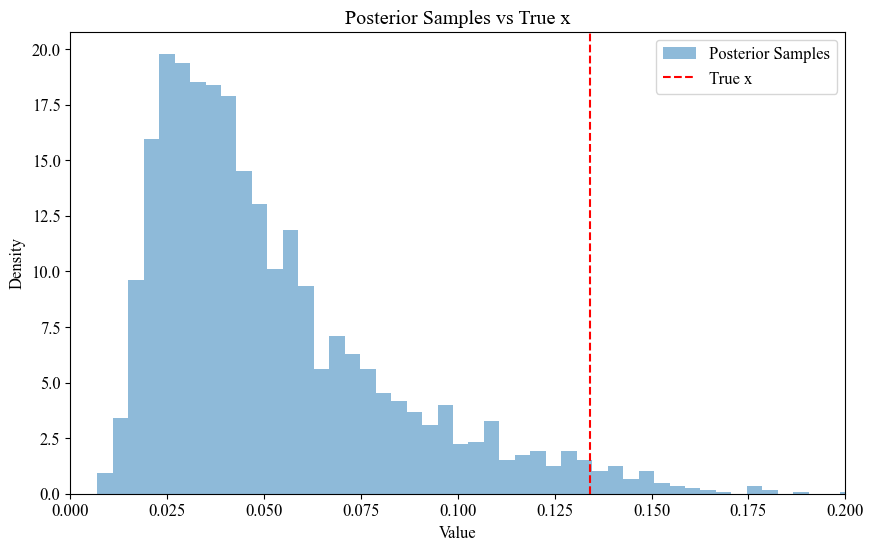

Training:  71%|███████   | 91/128 [08:09<04:12,  6.82s/it]

Epoch 91, Train Loss: 0.0705
Epoch 91, Train Reproduction Loss: 0.0115
Epoch 91, Train KLD Loss: 0.0820


Training:  72%|███████▏  | 92/128 [08:13<03:34,  5.97s/it]

Epoch 92, Train Loss: 0.0570
Epoch 92, Train Reproduction Loss: 0.0249
Epoch 92, Train KLD Loss: 0.0819


Training:  73%|███████▎  | 93/128 [08:17<03:08,  5.37s/it]

Epoch 93, Train Loss: 0.2829
Epoch 93, Train Reproduction Loss: -0.2006
Epoch 93, Train KLD Loss: 0.0824


Training:  73%|███████▎  | 94/128 [08:21<02:48,  4.97s/it]

Epoch 94, Train Loss: 0.1074
Epoch 94, Train Reproduction Loss: -0.0245
Epoch 94, Train KLD Loss: 0.0829


Training:  74%|███████▍  | 95/128 [08:25<02:33,  4.67s/it]

Epoch 95, Train Loss: -0.0377
Epoch 95, Train Reproduction Loss: 0.1187
Epoch 95, Train KLD Loss: 0.0810


Training:  75%|███████▌  | 96/128 [08:29<02:22,  4.46s/it]

Epoch 96, Train Loss: -0.0640
Epoch 96, Train Reproduction Loss: 0.1416
Epoch 96, Train KLD Loss: 0.0776


Training:  76%|███████▌  | 97/128 [08:33<02:13,  4.32s/it]

Epoch 97, Train Loss: -0.0256
Epoch 97, Train Reproduction Loss: 0.1052
Epoch 97, Train KLD Loss: 0.0797


Training:  77%|███████▋  | 98/128 [08:37<02:06,  4.23s/it]

Epoch 98, Train Loss: 0.1315
Epoch 98, Train Reproduction Loss: -0.0468
Epoch 98, Train KLD Loss: 0.0847


Training:  77%|███████▋  | 99/128 [08:41<02:00,  4.15s/it]

Epoch 99, Train Loss: 0.1504
Epoch 99, Train Reproduction Loss: -0.0695
Epoch 99, Train KLD Loss: 0.0809
Epoch 100, Train Loss: 0.0882
Epoch 100, Train Reproduction Loss: -0.0091
Epoch 100, Train KLD Loss: 0.0791
(1, 1)
(1,)


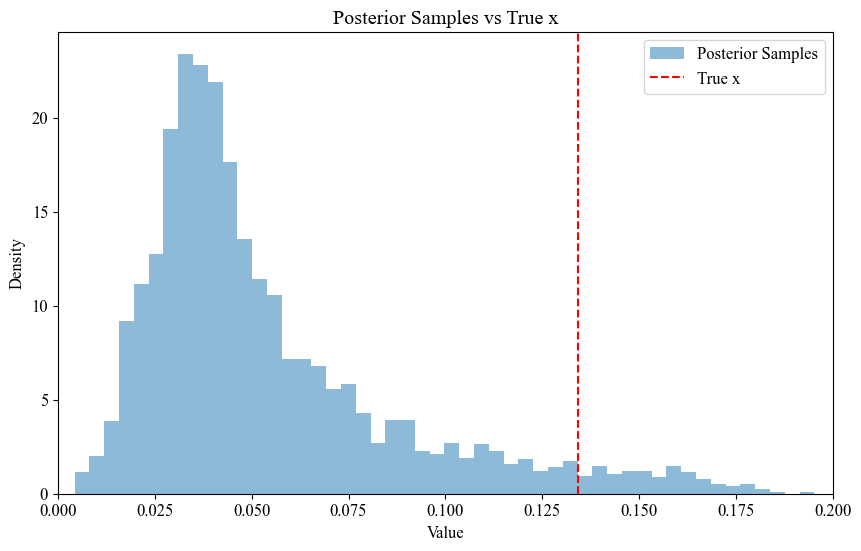

Training:  79%|███████▉  | 101/128 [09:02<03:03,  6.79s/it]

Epoch 101, Train Loss: -0.0387
Epoch 101, Train Reproduction Loss: 0.1184
Epoch 101, Train KLD Loss: 0.0797


Training:  80%|███████▉  | 102/128 [09:06<02:34,  5.95s/it]

Epoch 102, Train Loss: 0.0811
Epoch 102, Train Reproduction Loss: 0.0000
Epoch 102, Train KLD Loss: 0.0811


Training:  80%|████████  | 103/128 [09:09<02:13,  5.36s/it]

Epoch 103, Train Loss: 0.0594
Epoch 103, Train Reproduction Loss: 0.0225
Epoch 103, Train KLD Loss: 0.0819


Training:  81%|████████▏ | 104/128 [09:13<01:58,  4.94s/it]

Epoch 104, Train Loss: 0.2912
Epoch 104, Train Reproduction Loss: -0.2079
Epoch 104, Train KLD Loss: 0.0832


Training:  82%|████████▏ | 105/128 [09:17<01:46,  4.65s/it]

Epoch 105, Train Loss: -0.0198
Epoch 105, Train Reproduction Loss: 0.1001
Epoch 105, Train KLD Loss: 0.0803


Training:  83%|████████▎ | 106/128 [09:21<01:37,  4.45s/it]

Epoch 106, Train Loss: -0.0477
Epoch 106, Train Reproduction Loss: 0.1255
Epoch 106, Train KLD Loss: 0.0779


Training:  84%|████████▎ | 107/128 [09:25<01:30,  4.30s/it]

Epoch 107, Train Loss: -0.1181
Epoch 107, Train Reproduction Loss: 0.1966
Epoch 107, Train KLD Loss: 0.0784


Training:  84%|████████▍ | 108/128 [09:29<01:24,  4.21s/it]

Epoch 108, Train Loss: 0.0526
Epoch 108, Train Reproduction Loss: 0.0299
Epoch 108, Train KLD Loss: 0.0825


Training:  85%|████████▌ | 109/128 [09:33<01:18,  4.14s/it]

Epoch 109, Train Loss: -0.0243
Epoch 109, Train Reproduction Loss: 0.1052
Epoch 109, Train KLD Loss: 0.0808
Epoch 110, Train Loss: -0.0444
Epoch 110, Train Reproduction Loss: 0.1266
Epoch 110, Train KLD Loss: 0.0821
(1, 1)
(1,)


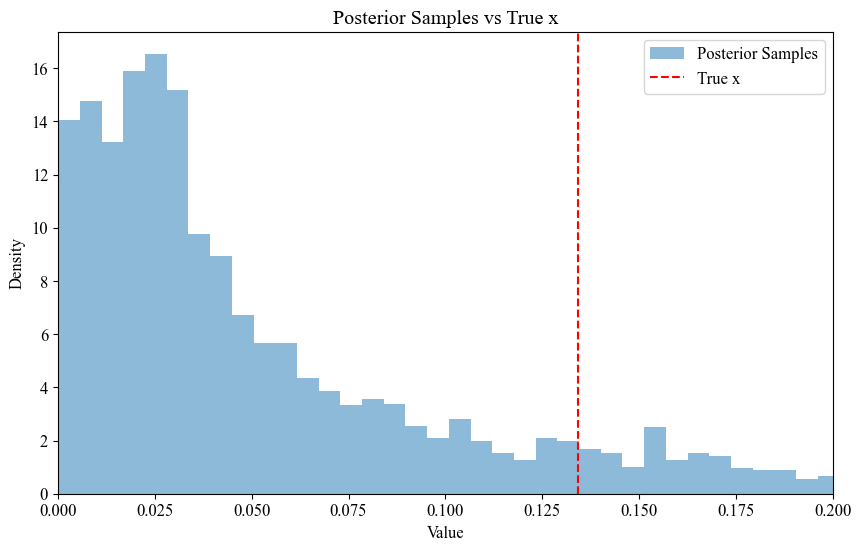

Training:  87%|████████▋ | 111/128 [09:54<01:55,  6.77s/it]

Epoch 111, Train Loss: 0.1581
Epoch 111, Train Reproduction Loss: -0.0743
Epoch 111, Train KLD Loss: 0.0838


Training:  88%|████████▊ | 112/128 [09:58<01:34,  5.93s/it]

Epoch 112, Train Loss: 0.0494
Epoch 112, Train Reproduction Loss: 0.0319
Epoch 112, Train KLD Loss: 0.0813


Training:  88%|████████▊ | 113/128 [10:02<01:20,  5.34s/it]

Epoch 113, Train Loss: 0.1460
Epoch 113, Train Reproduction Loss: -0.0636
Epoch 113, Train KLD Loss: 0.0824


Training:  89%|████████▉ | 114/128 [10:06<01:08,  4.93s/it]

Epoch 114, Train Loss: -0.0707
Epoch 114, Train Reproduction Loss: 0.1498
Epoch 114, Train KLD Loss: 0.0791


Training:  90%|████████▉ | 115/128 [10:10<01:00,  4.65s/it]

Epoch 115, Train Loss: -0.0746
Epoch 115, Train Reproduction Loss: 0.1533
Epoch 115, Train KLD Loss: 0.0787


Training:  91%|█████████ | 116/128 [10:14<00:53,  4.45s/it]

Epoch 116, Train Loss: 0.0228
Epoch 116, Train Reproduction Loss: 0.0587
Epoch 116, Train KLD Loss: 0.0815


Training:  91%|█████████▏| 117/128 [10:18<00:47,  4.30s/it]

Epoch 117, Train Loss: -0.0602
Epoch 117, Train Reproduction Loss: 0.1399
Epoch 117, Train KLD Loss: 0.0798


Training:  92%|█████████▏| 118/128 [10:22<00:42,  4.20s/it]

Epoch 118, Train Loss: -0.1042
Epoch 118, Train Reproduction Loss: 0.1851
Epoch 118, Train KLD Loss: 0.0809


Training:  93%|█████████▎| 119/128 [10:26<00:37,  4.14s/it]

Epoch 119, Train Loss: 0.0073
Epoch 119, Train Reproduction Loss: 0.0774
Epoch 119, Train KLD Loss: 0.0847
Epoch 120, Train Loss: -0.0150
Epoch 120, Train Reproduction Loss: 0.0961
Epoch 120, Train KLD Loss: 0.0811
(1, 1)
(1,)


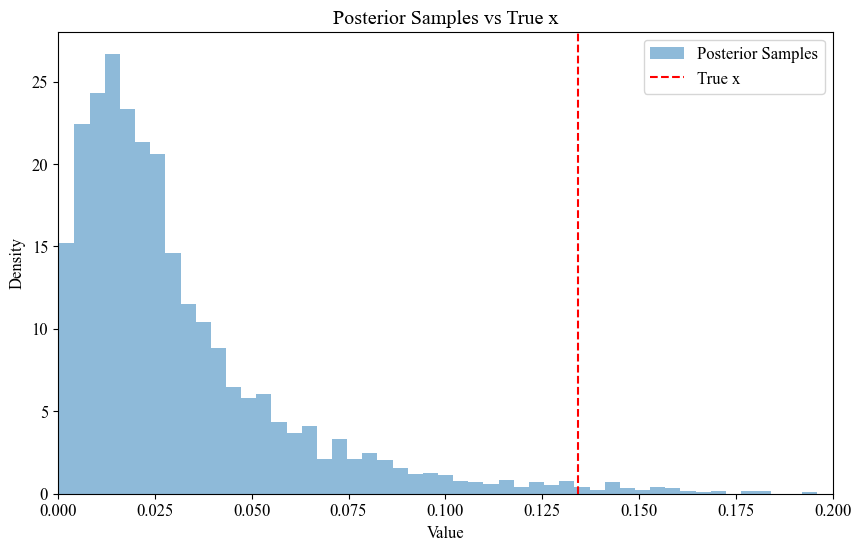

Training:  95%|█████████▍| 121/128 [10:47<00:47,  6.75s/it]

Epoch 121, Train Loss: 0.0155
Epoch 121, Train Reproduction Loss: 0.0636
Epoch 121, Train KLD Loss: 0.0792


Training:  95%|█████████▌| 122/128 [10:51<00:35,  5.91s/it]

Epoch 122, Train Loss: 0.0831
Epoch 122, Train Reproduction Loss: -0.0011
Epoch 122, Train KLD Loss: 0.0820


Training:  96%|█████████▌| 123/128 [10:55<00:26,  5.34s/it]

Epoch 123, Train Loss: -0.0155
Epoch 123, Train Reproduction Loss: 0.0962
Epoch 123, Train KLD Loss: 0.0807


Training:  97%|█████████▋| 124/128 [10:59<00:19,  4.94s/it]

Epoch 124, Train Loss: -0.0592
Epoch 124, Train Reproduction Loss: 0.1384
Epoch 124, Train KLD Loss: 0.0793


Training:  98%|█████████▊| 125/128 [11:03<00:13,  4.65s/it]

Epoch 125, Train Loss: 0.1027
Epoch 125, Train Reproduction Loss: -0.0217
Epoch 125, Train KLD Loss: 0.0810


Training:  98%|█████████▊| 126/128 [11:07<00:08,  4.45s/it]

Epoch 126, Train Loss: -0.0298
Epoch 126, Train Reproduction Loss: 0.1102
Epoch 126, Train KLD Loss: 0.0804


Training:  99%|█████████▉| 127/128 [11:11<00:04,  4.32s/it]

Epoch 127, Train Loss: -0.1076
Epoch 127, Train Reproduction Loss: 0.1879
Epoch 127, Train KLD Loss: 0.0803


Training: 100%|██████████| 128/128 [11:15<00:00,  5.28s/it]

Epoch 128, Train Loss: 0.0498
Epoch 128, Train Reproduction Loss: 0.0309
Epoch 128, Train KLD Loss: 0.0808
Training finished!


CVAE(
  (r1): Encoder(
    (fc_layers): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=512, out_features=512, bias=True)
      (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2)
    )
    (FC_means): Linear(in_features=512, out_features=32, bias=True)
    (FC_log_vars): Linear(in_features=512, out_features=32, bias=True)
  )
  (r2): Decoder(
    (fc_layers): Sequential(
      (0): Linear(in_features=544, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [14]:
print("Start training CVAE...")
avg_total_losses = []
avg_reproduction_losses = []
avg_kld_losses = []

avg_total_losses_validation = []
avg_reproduction_losses_validation = []
avg_kld_losses_validation = []

q_encoder_gradients = []
encoder_gradients = []
decoder_gradients = []

# validation data for validation
validation_y = []
validation_x = []
for y_validation, x_validation in validation_dataloader:
    validation_y.append(y_validation.to(DEVICE))
    validation_x.append(x_validation.to(DEVICE))

validation_y = torch.cat(validation_y, dim=0)
validation_x = torch.cat(validation_x, dim=0)


for epoch in tqdm(range(epochs), desc="Training"):
    overall_total_loss = 0
    overall_reproduction_loss = 0
    overall_kld_loss = 0

    overall_total_loss_validation = 0
    overall_reproduction_loss_validation = 0
    overall_kld_loss_validation = 0

    total_samples = 0

    for batch_idx, (y, x) in enumerate(train_dataloader, 0):
        cvae.train()
        y = y.view(x.size(0), -1)  # Reshape to (batch_size, 256) if needed
        y = y.to(DEVICE)
        # reshape to (batch_size, 1) if needed
        x = x.view(x.size(0), -1)  # Reshape to (batch_size, 256) if needed
        x = x.to(DEVICE)

        if log_beta:
            x = torch.log(x + 1e-8)

        optimizer.zero_grad()
        r2_x_mean, total_loss, recontruction_loss_x, KLD = cvae.forward(x, y, epoch)
        
        overall_total_loss += total_loss.item()
        overall_reproduction_loss += recontruction_loss_x.item()
        overall_kld_loss += KLD.item()
        total_samples += x.size(0)

        total_loss.backward()

        # compute gradients
        q_encoder_grad_norm = sum(p.grad.norm().item() for p in cvae.q.parameters() if p.grad is not None)
        encoder_grad_norm = sum(p.grad.norm().item() for p in cvae.r1.parameters() if p.grad is not None)
        decoder_grad_norm = sum(p.grad.norm().item() for p in cvae.r2.parameters() if p.grad is not None)

        q_encoder_gradients.append(q_encoder_grad_norm)
        encoder_gradients.append(encoder_grad_norm)
        decoder_gradients.append(decoder_grad_norm)

        optimizer.step()

        # validation losses
        cvae.eval()
        # with torch.no_grad():
            # x_validation = validation_data
            # y_validation = validation_conditions
            # x_validation = x_validation.view(x_validation.size(0), -1).to(DEVICE)
            # x_hat_validation, mean_validation, log_var_validation = model(x_validation, y_validation)
            # total_loss_validation, reproduction_loss_validation, kld_loss_validation = loss_function(x_validation, x_hat_validation, mean_validation, log_var_validation)

    # summarise training losses
    avg_total_loss = overall_total_loss / total_samples
    print(f"Epoch {epoch+1}, Train Loss: {avg_total_loss:.4f}")
    avg_reproduction_loss = overall_reproduction_loss / total_samples
    print(f"Epoch {epoch+1}, Train Reproduction Loss: {avg_reproduction_loss:.4f}")
    avg_kld_loss = overall_kld_loss / total_samples
    print(f"Epoch {epoch+1}, Train KLD Loss: {avg_kld_loss:.4f}")
    
    avg_total_losses.append(avg_total_loss)
    avg_reproduction_losses.append(avg_reproduction_loss)
    avg_kld_losses.append(avg_kld_loss)

    # summarise validation losses
    # avg_total_loss_validation = total_loss_validation.item() / x_validation.size(0)
    # avg_reproduction_loss_validation = reproduction_loss_validation.item() / x_validation.size(0)
    # avg_kld_loss_validation = kld_loss_validation.item() / x_validation.size(0)

    # avg_total_losses_validation.append(avg_total_loss_validation)
    # avg_reproduction_losses_validation.append(avg_reproduction_loss_validation)
    # avg_kld_losses_validation.append(avg_kld_loss_validation)

    # tqdm.write(f'Epoch {epoch+1}, Train Loss: {avg_total_loss:.4f}, Val Loss: {avg_total_loss_validation:.4f}')

    if (epoch + 1) % 10 == 0:
    #     x = x.cpu().detach()
    #     x_hat = x_hat.cpu().detach()
    #     plot_reconstruction(x[0], x_hat[0], max_value=train_dataset.max_value)

    #     with torch.no_grad():
    #         generated_signals = model.decoder(noise, condition_noise).cpu().detach().numpy()
        
    #     plot_waveform_grid(signals=generated_signals, max_value=train_dataset.max_value)

    #     idx1 = torch.randint(0, x.size(0), (1,)).item()
    #     idx2 = idx1

    #     while idx2 == idx1: # ensures we don't sample the same signal
    #         idx2 = torch.randint(0, x.size(0), (1,)).item()

    #     signal_1 = x[idx1].to(DEVICE)
    #     signal_2 = x[idx2].to(DEVICE)
    #     condition_1 = y[idx1].to(DEVICE)
    #     condition_2 = y[idx2].to(DEVICE)
        
    #     plot_latent_morphs(model_conditional, signal_1, signal_2, max_value=train_dataset.max_value, steps=8)

        # posterior test samples
        with torch.no_grad():
            x_samples = cvae.posterior_samples(validation_y[0, :], 3000)
        x_samples = x_samples[:, 0]
        
        if log_beta:
            x_samples = torch.exp(x_samples)

        # Plot histogram of posterior samples
        plt.figure(figsize=(10, 6))
        plt.hist(x_samples.cpu().numpy(), bins=50, alpha=0.5, label='Posterior Samples', density=True)

        # Add a vertical line for the true value
        true_value = validation_x[0].cpu().numpy()
        print(true_value.shape)
        true_value = true_value[:, 0]
        print(true_value.shape)
        plt.axvline(true_value, color='red', linestyle='--', label='True x')
        plt.xlim(0, 0.2)
        plt.title('Posterior Samples vs True x')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

print("Training finished!")
cvae.eval()

### Training and Validation Loss

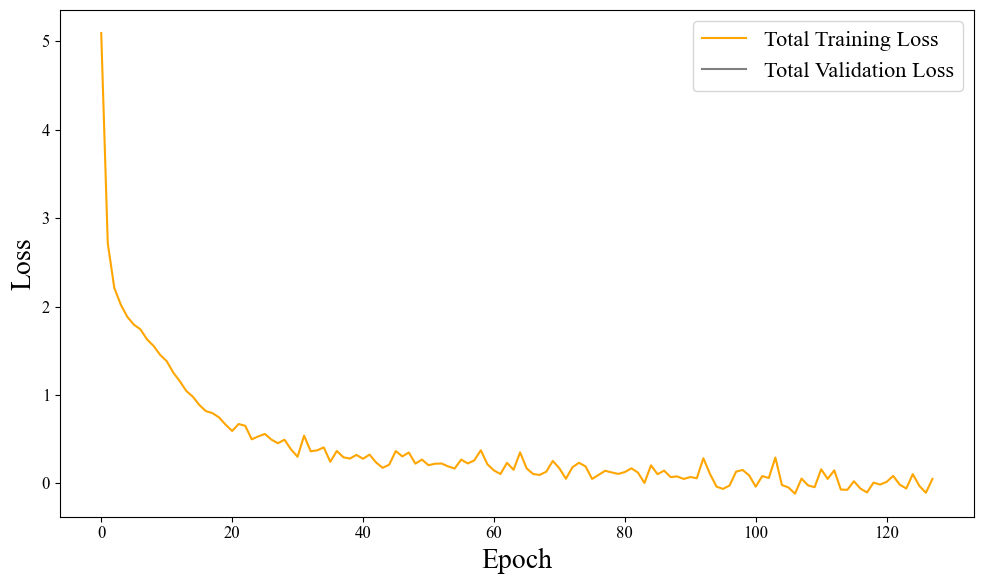

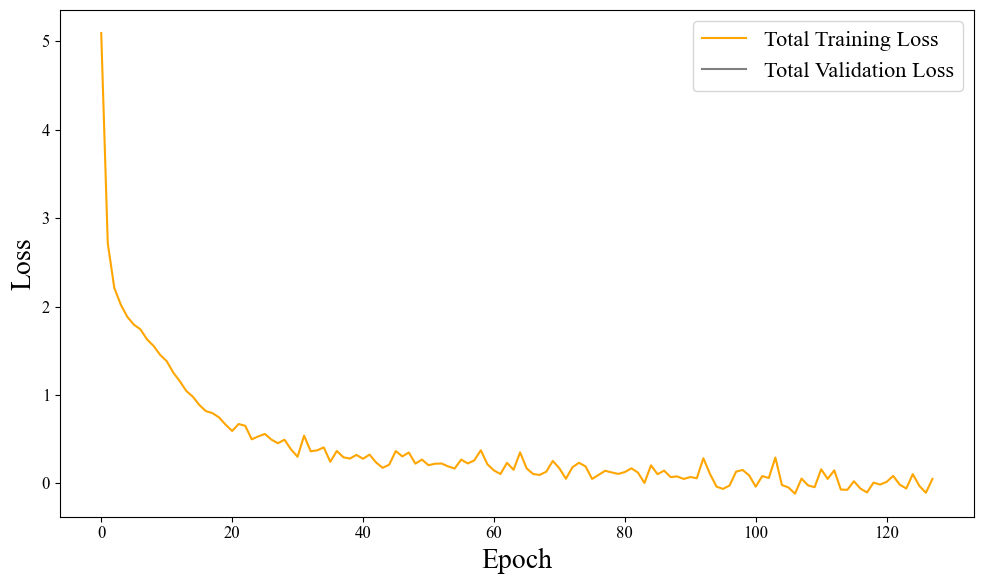

In [15]:
plot_training_validation_loss(avg_total_losses, avg_total_losses_validation)

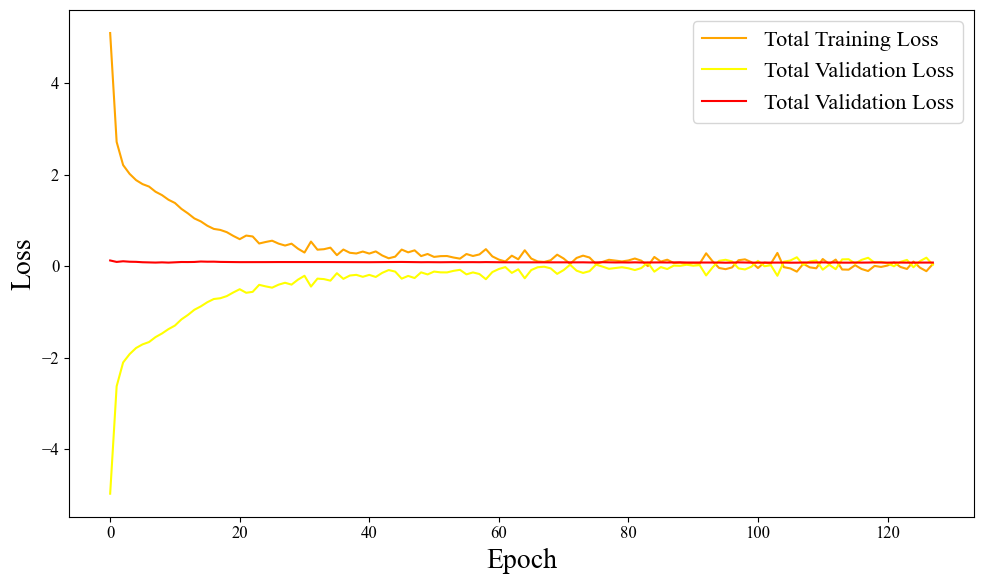

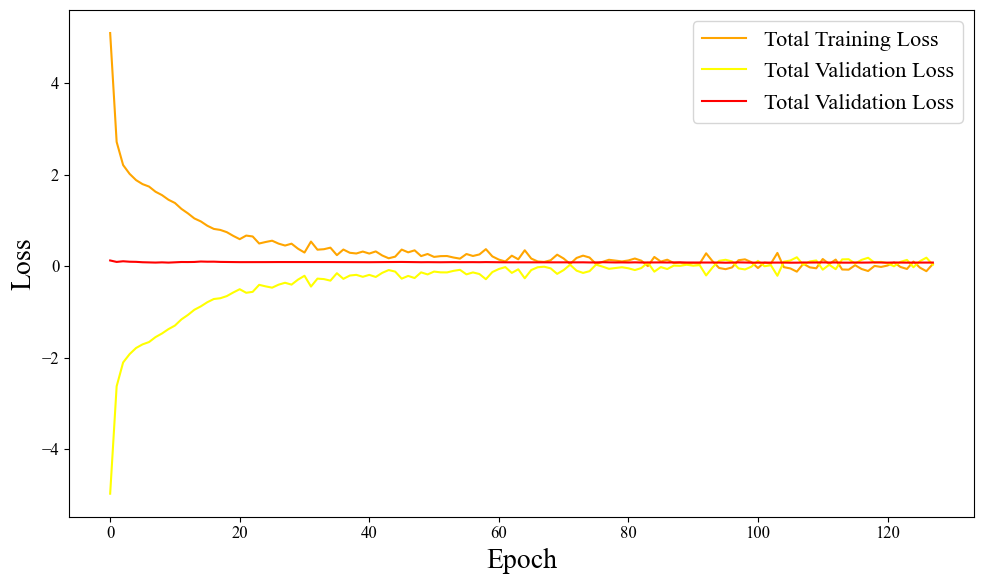

In [16]:
plot_individual_loss(avg_total_losses, avg_reproduction_losses, avg_kld_losses)

### Morph Animation

In [ ]:
# select signals here

# plot and save animations
# signal_1 = x[0].to(fffDEVICE)
# signal_2 = x[7].to(DEVICE)
# animate_latent_morphs(model, signal_1, signal_2, train_dataset.max_value, train_dataset, steps=100, interval=200, save_path="latent_morph_animation_3.gif")

NameError: name 'fffDEVICE' is not defined

### Plot Encoder and Decoder Gradient Norms

In [ ]:
plot_gradients(q_gradients=q_encoder_gradients, encoder_gradients=encoder_gradients, decoder_gradients=decoder_gradients)